The dataset Tiny ImageNet has to be in the 'data/' folder

Instruction to download and extract the data:

wget http://cs231n.stanford.edu/tiny-imagenet-200.zip

unzip tiny-imagenet-200.zip

rm tiny-imagenet-200.zip

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices()) 

import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


['/device:CPU:0', '/device:GPU:0']


# 0. Loading the data

### TinyImageNet does not have labels for the testing data. We will use the 10k validation images for the testing data.

In [2]:
#Generate dataset
from utils.tiny_imageNet import labels_order
###### TRAINING DATA #######
#Load Training images and labels
train_directory = "./data/tiny-imagenet-200/train" 
image_list=[]
label_list=[]

label_dic=labels_order() #convert label str to int from 0 



for l,sub_dir in enumerate(os.listdir(train_directory)):
    if not sub_dir in label_dic:
        label_dic[sub_dir]=l
    sub_dir_name=os.path.join(train_directory,sub_dir,'images')
    n=0
    for file in os.listdir(sub_dir_name):
        filename = os.fsdecode(file)
        if filename.endswith(".JPEG")  or filename.endswith(".jpg") or filename.endswith(".png"):
            img=np.array(Image.open(os.path.join(sub_dir_name,file)))
            if(img.shape == (64, 64, 3)): #removing images without 3 channels
                image_list.append(img)
                label_list.append(int(label_dic[sub_dir]))
                n+=1
    print(n,'pictures in folder',sub_dir,sep=' ' )
            
X_tot=np.array(image_list)
y_tot=np.array(label_list)

###### TEST DATA #######

#getting the labels from the txt file
df = pd.read_table('./data/tiny-imagenet-200/val/val_annotations.txt', header=None)
test_labels={} 
for index, row in df.iterrows():
    test_labels[str(row[0])]= row[1]


test_directory = "./data/tiny-imagenet-200/val/images" 

test_image_list=[]
test_label_list=[]

for file in os.listdir(test_directory):
    filename = os.fsdecode(file)
  
    if filename.endswith(".JPEG")  or filename.endswith(".jpg") or filename.endswith(".png"):
        img=np.array(Image.open(os.path.join(test_directory,file)))
        if(img.shape == (64, 64, 3)): #removing images without 3 channels
            test_image_list.append(img)
            test_label_list.append(label_dic[test_labels[filename]])
            
X_test=np.array(test_image_list)
y_test=tf.keras.utils.to_categorical(np.array(test_label_list))

497 pictures in folder n03617480
499 pictures in folder n09332890
499 pictures in folder n01917289
497 pictures in folder n04398044
496 pictures in folder n03977966
491 pictures in folder n04486054
485 pictures in folder n02481823
499 pictures in folder n01910747
500 pictures in folder n01443537
495 pictures in folder n02823428
497 pictures in folder n04254777
487 pictures in folder n03837869
500 pictures in folder n07695742
493 pictures in folder n03983396
500 pictures in folder n04597913
495 pictures in folder n02395406
500 pictures in folder n02132136
492 pictures in folder n04259630
500 pictures in folder n02279972
493 pictures in folder n04371430
500 pictures in folder n03980874
454 pictures in folder n03763968
499 pictures in folder n07768694
497 pictures in folder n02948072
497 pictures in folder n02231487
497 pictures in folder n02206856
494 pictures in folder n09428293
498 pictures in folder n03100240
473 pictures in folder n04532670
495 pictures in folder n01944390
495 pictur

In [3]:
shuffler=np.random.RandomState(seed=10).permutation(len(X_tot))
X_tot = X_tot[shuffler]
y_tot = y_tot[shuffler]
y_tot=tf.keras.utils.to_categorical(y_tot)

X_train = X_tot[5000:]
y_train =  y_tot[5000:]
X_val = X_tot[:5000]
y_val =  y_tot[:5000]


print('test data:')
print(X_test.shape)
print(y_test.shape)

print('train data:')
print(X_train.shape)
print(y_train.shape)

print('val data:')
print(X_val.shape)
print(y_val.shape)

test data:
(9832, 64, 64, 3)
(9832, 200)
train data:
(93179, 64, 64, 3)
(93179, 200)
val data:
(5000, 64, 64, 3)
(5000, 200)


#### Saving the variables allows faster loading in the future

In [4]:
#save for future use without having to reload from the images folders
np.save('data/X_test.npy', X_test)
np.save('data/y_test.npy', y_test)
np.save('data/X_train.npy', X_train)
np.save('data/y_train.npy', y_train)
np.save('data/X_val.npy', X_val)
np.save('data/y_val.npy', y_val) 



In [2]:
print('script running in '+os.path.abspath("."))
X_test = np.load('./data/X_test.npy')
y_test = np.load('./data/y_test.npy')
X_train = np.load('./data/X_train.npy')
y_train = np.load('./data/y_train.npy')
X_val = np.load('./data/X_val.npy')
y_val = np.load('./data/y_val.npy')

script running in /home/ecbm4040/envTF24/e4040-2021fall-project-fren-an3078-wab2138-av3023


## 3.1 Resnet50 without data augmentation

In [3]:
from utils.custom_resnet import custom_resnet50
from utils.train_TinyImageNet_SE_ResNet import tinyImageNet_resnet_train
# tinyImageNet_resnet_train(model,path,X_train,y_train,X_val,y_val,data_aug=False,learning_rate=0.6,steps=14,epochs=45,batch_size=128,es_patience=8)
resnet_50=custom_resnet50(input_shape=(64,64,3),n_classes=200)
resnet_50.summary()

Model: "custom_resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 32, 32, 64)   0           conv1_bn[0][0]                   
____________________________________________________________________________________

In [4]:
hist_resnet_50= tinyImageNet_resnet_train(resnet_50,
                          './models/tinyImageNet/resnet_50_best.hdf5', #path for weights of best model
                          X_train,y_train,
                          X_val,
                          y_val,
                          data_aug=False, #no data aug
                          learning_rate=0.6, #starting learning rate
                          steps=20, #number of epochs between learning rate modification (* 0.1)
                          epochs=60,
                          batch_size=128,
                          es_patience=20) #early stopping

Epoch 1/60
steps before lr change:  20

Epoch 00001: LearningRateScheduler reducing learning rate to 0.6000000238418579.
727/727 [==============================] - 112s 142ms/step - loss: 6.9869 - acc: 0.0074 - val_loss: 5.1914 - val_acc: 0.0082

Epoch 00001: val_acc improved from -inf to 0.00820, saving model to ./models/tinyImageNet/resnet_50_best.hdf5
Epoch 2/60
steps before lr change:  19

Epoch 00002: LearningRateScheduler reducing learning rate to 0.6000000238418579.
727/727 [==============================] - 100s 137ms/step - loss: 5.1483 - acc: 0.0118 - val_loss: 5.0686 - val_acc: 0.0200

Epoch 00002: val_acc improved from 0.00820 to 0.02000, saving model to ./models/tinyImageNet/resnet_50_best.hdf5
Epoch 3/60
steps before lr change:  18

Epoch 00003: LearningRateScheduler reducing learning rate to 0.6000000238418579.
727/727 [==============================] - 100s 137ms/step - loss: 5.0592 - acc: 0.0179 - val_loss: 5.0587 - val_acc: 0.0214

Epoch 00003: val_acc improved from 0

## Early stopping, learning rate reduction was used, best model was saved

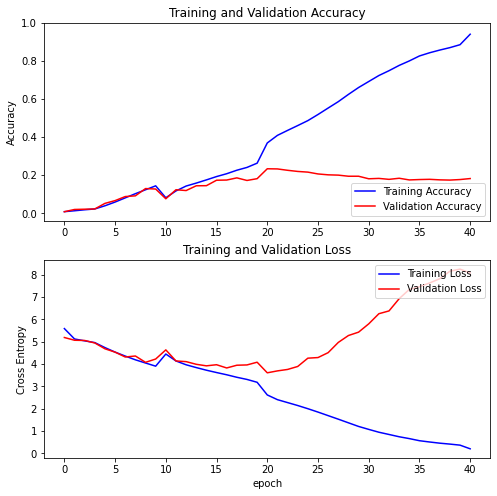

In [5]:
from utils.train_TinyImageNet_SE_ResNet import plot_model
plot_model(hist_resnet_50)

In [4]:
# Evaluate the model
# reload from saved weights:
model = custom_resnet50(input_shape=(64,64,3),n_classes=200)
model.load_weights('./models/tinyImageNet/resnet_50_best.hdf5')
print('weights loaded')

model.save('./full_models/tinyImageNet/resnet_50_best.h5')#
del model  # deletes the existing model       #
model = tf.keras.models.load_model('./full_models/tinyImageNet/resnet_50_best.h5')#

# Evaluate the model
model.compile(loss='categorical_crossentropy', metrics = ['acc'])
loss, acc = model.evaluate(X_test, y_test, verbose=2)
print("best saved model, accuracy: {:5.2f}%".format(100 * acc))

from utils.evaluate_model import score
score(model,X_test,y_test,[1,3,5])

weights loaded
308/308 - 9s - loss: 3.5586 - acc: 0.2381
best saved model, accuracy: 23.81%
308/308 - 6s - loss: 3.5586 - acc: 0.2381
custom_resnet50
model accuracy: 23.81%
top 1 accuracy: 23.81000816822052
top 3 accuracy: 39.971521496772766
top 5 accuracy: 48.91171753406525


## 3.2 Resnet50 with data augmentation

In [4]:
from utils.train_TinyImageNet_SE_ResNet import tinyImageNet_resnet_train,plot_model
from utils.custom_resnet import custom_resnet50

resnet_50_aug=custom_resnet50(input_shape=(64,64,3),n_classes=200)
path='./models/tinyImageNet/resnet_50_aug_best.hdf5'
history_resnet_50_aug= tinyImageNet_resnet_train(resnet_50_aug,
                          path, #path for weights of best model
                          X_train,y_train,
                          X_val,
                          y_val,
                          data_aug=True, #no data aug
                          learning_rate=0.6, #starting learning rate
                          steps=20, #number of epochs between learning rate modification (* 0.1)
                          epochs=60,
                          batch_size=128,
                          es_patience=20) #early stopping

Epoch 1/60
steps before lr change:  20

Epoch 00001: LearningRateScheduler reducing learning rate to 0.6000000238418579.
727/727 [==============================] - 138s 178ms/step - loss: 7.0220 - acc: 0.0074 - val_loss: 5.1467 - val_acc: 0.0112

Epoch 00001: val_acc improved from -inf to 0.01120, saving model to ./models/tinyImageNet/resnet_50_aug_best.hdf5
Epoch 2/60
steps before lr change:  19

Epoch 00002: LearningRateScheduler reducing learning rate to 0.6000000238418579.
727/727 [==============================] - 126s 173ms/step - loss: 5.1399 - acc: 0.0121 - val_loss: 5.0882 - val_acc: 0.0142

Epoch 00002: val_acc improved from 0.01120 to 0.01420, saving model to ./models/tinyImageNet/resnet_50_aug_best.hdf5
Epoch 3/60
steps before lr change:  18

Epoch 00003: LearningRateScheduler reducing learning rate to 0.6000000238418579.
727/727 [==============================] - 126s 173ms/step - loss: 5.0815 - acc: 0.0172 - val_loss: 4.9853 - val_acc: 0.0224

Epoch 00003: val_acc improve

## Early stopping, learning rate reduction was used, best model was saved

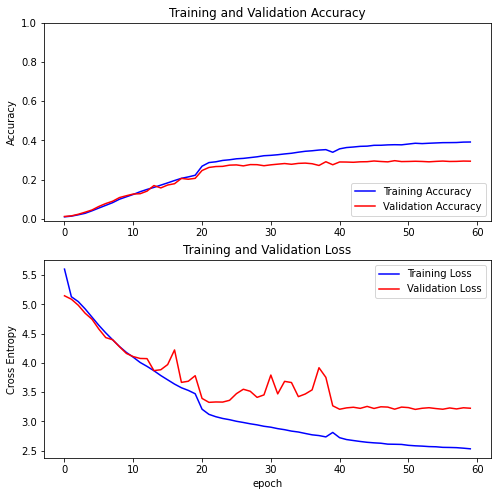

In [5]:
plot_model(history_resnet_50_aug)

In [5]:
# reload from saved weights:
from utils.custom_resnet import custom_resnet50 #
path='./models/tinyImageNet/resnet_50_aug_best.hdf5' #
model = custom_resnet50(input_shape=(64,64,3),n_classes=200)
model.load_weights(path)

model.save('./full_models/tinyImageNet/resnet_50_aug_best.h5')#
del model  # deletes the existing model       #
model = tf.keras.models.load_model('./full_models/tinyImageNet/resnet_50_aug_best.h5')#

# Evaluate the model
from utils.evaluate_model import score
score(model,X_test,y_test,[1,3,5])

308/308 - 6s - loss: 3.2277 - acc: 0.2980
custom_resnet50
model accuracy: 29.80%
top 1 accuracy: 29.800650477409363
top 3 accuracy: 47.19283878803253
top 5 accuracy: 55.970299243927


## 4.1 SE-ResNet50 without data augmentation

In [7]:
from utils.SE_resnet import SE_resnet50

SE_resnet50=SE_resnet50(input_shape=(64,64,3),n_classes=200,name='SE_resnet50')
SE_resnet50.summary()

Model: "SE_custom_resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        input_3[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[1][0]                 
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 32, 32, 64)   0           conv1_bn[1][0]                   
_________________________________________________________________________________

In [8]:
path='./models/tinyImageNet/SE-resnet_50_best.hdf5'
history_SEresnet_50= tinyImageNet_resnet_train(SE_resnet50,
                          path, #path for weights of best model
                          X_train,y_train,
                          X_val,
                          y_val,
                          data_aug=False, #no data aug
                          learning_rate=0.6, #starting learning rate
                          steps=20, #number of epochs between learning rate modification (* 0.1)
                          epochs=60,
                          batch_size=128,
                          es_patience=20) #early stopping

Epoch 1/60
steps before lr change:  20

Epoch 00001: LearningRateScheduler reducing learning rate to 0.6000000238418579.
727/727 [==============================] - 126s 166ms/step - loss: 5.8374 - acc: 0.0071 - val_loss: 5.1435 - val_acc: 0.0128

Epoch 00001: val_acc improved from -inf to 0.01280, saving model to ./models/tinyImageNet/SE-resnet_50_best.hdf5
Epoch 2/60
steps before lr change:  19

Epoch 00002: LearningRateScheduler reducing learning rate to 0.6000000238418579.
727/727 [==============================] - 119s 164ms/step - loss: 5.1156 - acc: 0.0150 - val_loss: 5.0669 - val_acc: 0.0206

Epoch 00002: val_acc improved from 0.01280 to 0.02060, saving model to ./models/tinyImageNet/SE-resnet_50_best.hdf5
Epoch 3/60
steps before lr change:  18

Epoch 00003: LearningRateScheduler reducing learning rate to 0.6000000238418579.
727/727 [==============================] - 120s 165ms/step - loss: 5.0208 - acc: 0.0198 - val_loss: 5.0032 - val_acc: 0.0278

Epoch 00003: val_acc improved 

## Early stopping, learning rate reduction was used, best model was saved

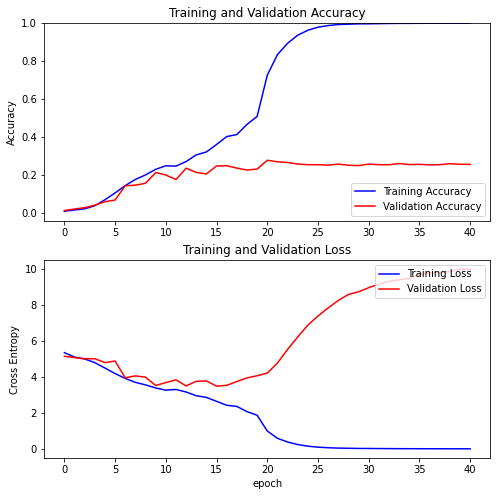

In [9]:
plot_model(history_SEresnet_50)

In [8]:
# reload from saved weights:
from utils.SE_resnet import SE_resnet50
path='./models/tinyImageNet/SE-resnet_50_best.hdf5' #
model = SE_resnet50(input_shape=(64,64,3),n_classes=200,name='SE_resnet50')
model.load_weights(path)

model.save('./full_models/tinyImageNet/SE-resnet_50_best.h5')#
del model  # deletes the existing model       #
model = tf.keras.models.load_model('./full_models/tinyImageNet/SE-resnet_50_best.h5')#

# Evaluate the model
from utils.evaluate_model import score
score(model,X_test,y_test,[1,3,5])

308/308 - 7s - loss: 4.2771 - acc: 0.2819
SE_custom_resnet50
model accuracy: 28.19%
top 1 accuracy: 28.193652629852295
top 3 accuracy: 44.48738694190979
top 5 accuracy: 52.28844881057739


## 4.2 SE-ResNet50 with data augmentation

In [4]:
from utils.SE_resnet import SE_resnet50
SE_resnet50_aug=SE_resnet50(input_shape=(64,64,3),n_classes=200,name='SE_resnet50_aug')

path='./models/tinyImageNet/SE-resnet_50_aug_best.hdf5'
history_SEresnet_50_aug= tinyImageNet_resnet_train(SE_resnet50_aug,
                          path, #path for weights of best model
                          X_train,y_train,
                          X_val,
                          y_val,
                          data_aug=True, #no data aug
                          learning_rate=0.6, #starting learning rate
                          steps=20, #number of epochs between learning rate modification (* 0.1)
                          epochs=60,
                          batch_size=128,
                          es_patience=20) #early stopping

Epoch 1/60
steps before lr change:  20

Epoch 00001: LearningRateScheduler reducing learning rate to 0.6000000238418579.
727/727 [==============================] - 146s 185ms/step - loss: 5.8034 - acc: 0.0084 - val_loss: 5.0202 - val_acc: 0.0178

Epoch 00001: val_acc improved from -inf to 0.01780, saving model to ./models/tinyImageNet/SE-resnet_50_aug_best.hdf5
Epoch 2/60
steps before lr change:  19

Epoch 00002: LearningRateScheduler reducing learning rate to 0.6000000238418579.
727/727 [==============================] - 130s 179ms/step - loss: 4.9680 - acc: 0.0244 - val_loss: 4.8529 - val_acc: 0.0386

Epoch 00002: val_acc improved from 0.01780 to 0.03860, saving model to ./models/tinyImageNet/SE-resnet_50_aug_best.hdf5
Epoch 3/60
steps before lr change:  18

Epoch 00003: LearningRateScheduler reducing learning rate to 0.6000000238418579.
727/727 [==============================] - 129s 178ms/step - loss: 4.7047 - acc: 0.0473 - val_loss: 4.5097 - val_acc: 0.0734

Epoch 00003: val_acc i

## Early stopping, learning rate reduction was used, best model was saved

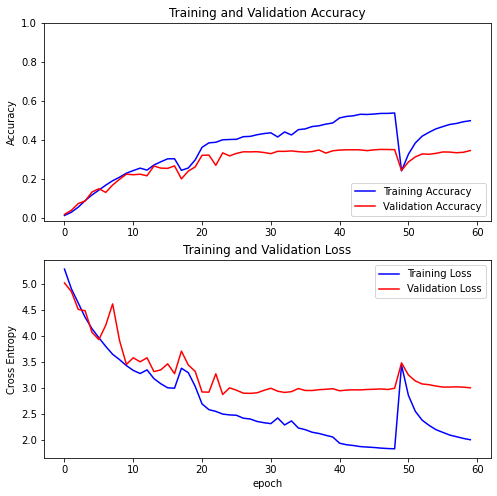

In [5]:
plot_model(history_SEresnet_50_aug)

In [9]:
# reload from saved weights:
from utils.SE_resnet import SE_resnet50
path='./models/tinyImageNet/SE-resnet_50_aug_best.hdf5' #
model = SE_resnet50(input_shape=(64,64,3),n_classes=200,name='SE_resnet50_aug')
model.load_weights(path)

model.save('./full_models/tinyImageNet/SE-resnet_50_aug_best.h5')#
del model  # deletes the existing model       #
model = tf.keras.models.load_model('./full_models/tinyImageNet/SE-resnet_50_aug_best.h5')#

# Evaluate the model
from utils.evaluate_model import score
score(model,X_test,y_test,[1,3,5])

308/308 - 7s - loss: 2.9517 - acc: 0.3592
SE_custom_resnet50
model accuracy: 35.92%
top 1 accuracy: 35.923513770103455
top 3 accuracy: 53.97680997848511
top 5 accuracy: 61.47274374961853
